# The credit fraud dataset - Synthesizing the minority class
In this notebook it's presented a practical exercise of how to use the avilable library GANs to synthesize tabular data.
For the purpose of this exercise it has been used the Credit Fraud dataset from Kaggle, that you can find here:https: //www.kaggle.com/mlg-ulb/creditcardfraud

In [ ]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [ ]:
!pip install --force-reinstall --no-deps https://github.com/ceshine/ydata-synthetic/archive/master.zip

In [ ]:
# Install ydata-synthetic lib
# !pip install --no-deps git+https://github.com/ydataai/ydata-synthetic.git
!pip install -U pmlb tensorflow-privacy watermark

In [ ]:
%load_ext watermark
%watermark -p tensorflow,pandas -z -v -n -m -w

Sun Dec 13 2020 UTC 

CPython 3.6.9
IPython 5.5.0

tensorflow 2.3.0
pandas 1.1.5

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
watermark 2.0.2


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
!cp /gdrive/My\ Drive/colab\ tmp/credit_fraud.zip . 
!unzip credit_fraud.zip

In [ ]:
import importlib
import sys  

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import WGAN_GP
from ydata_synthetic.preprocessing.credit_fraud import *

In [ ]:
#Read the original data and have it preprocessed
data = pd.read_csv('creditcard.csv', index_col=[0])

In [ ]:
label_cols = [ i for i in data.columns if 'Class' in i ]
data_cols = [ i for i in data.columns if i not in label_cols ]

print('Dataset columns: {}'.format(", ".join(data_cols)))

Dataset columns: V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount


In [ ]:
# #Before training the GAN do not forget to apply the required data transformations
# #To ease here we've applied a PowerTransformation
# data = transformations(data)

# #For the purpose of this example we will only synthesize the minority class
# train_data = data.loc[ data['Class']==1 ].copy()

# print("Dataset info: Number of records - {} Number of varibles - {}".format(train_data.shape[0], train_data.shape[1]))

# algorithm = cluster.KMeans
# args, kwds = (), {'n_clusters':2, 'random_state':0}
# labels = algorithm(*args, **kwds).fit_predict(train_data[ data_cols ])

# print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

# fraud_w_classes = train_data.copy()
# fraud_w_classes['Class'] = labels

## Split the Data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
sss_1 = StratifiedShuffleSplit(test_size=0.4, random_state=42)
sss_2 = StratifiedShuffleSplit(test_size=0.5, random_state=42)
data = pd.read_csv('creditcard.csv', index_col=[0])[data_cols + ["Class"]]
#Before training the GAN do not forget to apply the required data transformations
#To ease here we've applied a PowerTransformation
data = transformations(data)
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
sampled_data = pd.concat([data[data.Class == 1], data[data.Class==0].sample(20000)], axis=0)
train_idx, test_idx = next(sss_1.split(sampled_data, sampled_data["Class"]))
X_train, X_test, y_train, y_test = sampled_data.iloc[train_idx][data_cols], sampled_data.iloc[test_idx][data_cols], sampled_data.iloc[train_idx]["Class"], sampled_data.iloc[test_idx]["Class"]
valid_idx, test_idx = next(sss_2.split(X_test, y_test))
X_valid, X_test, y_valid, y_test = X_test.iloc[valid_idx], X_test.iloc[test_idx], y_test.iloc[valid_idx], y_test.iloc[test_idx]
X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((12295, 29), (4099, 29), (4098, 29), (12295,), (4099,), (4098,))

# GAN training

Below you can try to train your own generators using the available GANs architectures. You can train it either with labels (created using KMeans) or with no labels at all. 

Remeber that for this exercise in particular we've decided to synthesize only the minority class from the Credit Fraud dataset.

In [ ]:
#Define the GAN and training parameters
noise_dim = 32
dim = 64
batch_size = 192

log_step = 100
epochs = 1200+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, X_train.shape[1], dim]
train_args = ['', epochs, log_step]
train_samples = X_train[y_train==1].reset_index(drop=True)
train_samples.shape

(295, 29)

In [ ]:
#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = WGAN_GP(gan_args, n_critic=4)
# Only generate fraud data
synthesizer.train(train_samples, train_args)

In [ ]:
# Generator discription
synthesizer.generator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(192, 32)]               0         
_________________________________________________________________
dense (Dense)                (192, 64)                 2112      
_________________________________________________________________
dense_1 (Dense)              (192, 128)                8320      
_________________________________________________________________
dense_2 (Dense)              (192, 256)                33024     
_________________________________________________________________
dense_3 (Dense)              (192, 29)                 7453      
Total params: 50,909
Trainable params: 50,909
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Critic description
synthesizer.critic.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(192, 29)]               0         
_________________________________________________________________
dense_4 (Dense)              (192, 256)                7680      
_________________________________________________________________
dropout (Dropout)            (192, 256)                0         
_________________________________________________________________
dense_5 (Dense)              (192, 128)                32896     
_________________________________________________________________
dropout_1 (Dropout)          (192, 128)                0         
_________________________________________________________________
dense_6 (Dense)              (192, 64)                 8256      
_________________________________________________________________
dense_7 (Dense)              (192, 1)                 

In [ ]:
!mkdir -p saved/gan
#You can easily save the trained generator and loaded it aftwerwards
synthesizer.save('./saved/gan', 'generator_fraud')

In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

In [ ]:
!ls cache/

_critic_model_weights_step_0.h5     _generator_model_weights_step_0.h5
_critic_model_weights_step_1000.h5  _generator_model_weights_step_1000.h5
_critic_model_weights_step_100.h5   _generator_model_weights_step_100.h5
_critic_model_weights_step_1100.h5  _generator_model_weights_step_1100.h5
_critic_model_weights_step_1200.h5  _generator_model_weights_step_1200.h5
_critic_model_weights_step_200.h5   _generator_model_weights_step_200.h5
_critic_model_weights_step_300.h5   _generator_model_weights_step_300.h5
_critic_model_weights_step_400.h5   _generator_model_weights_step_400.h5
_critic_model_weights_step_500.h5   _generator_model_weights_step_500.h5
_critic_model_weights_step_600.h5   _generator_model_weights_step_600.h5
_critic_model_weights_step_700.h5   _generator_model_weights_step_700.h5
_critic_model_weights_step_800.h5   _generator_model_weights_step_800.h5
_critic_model_weights_step_900.h5   _generator_model_weights_step_900.h5


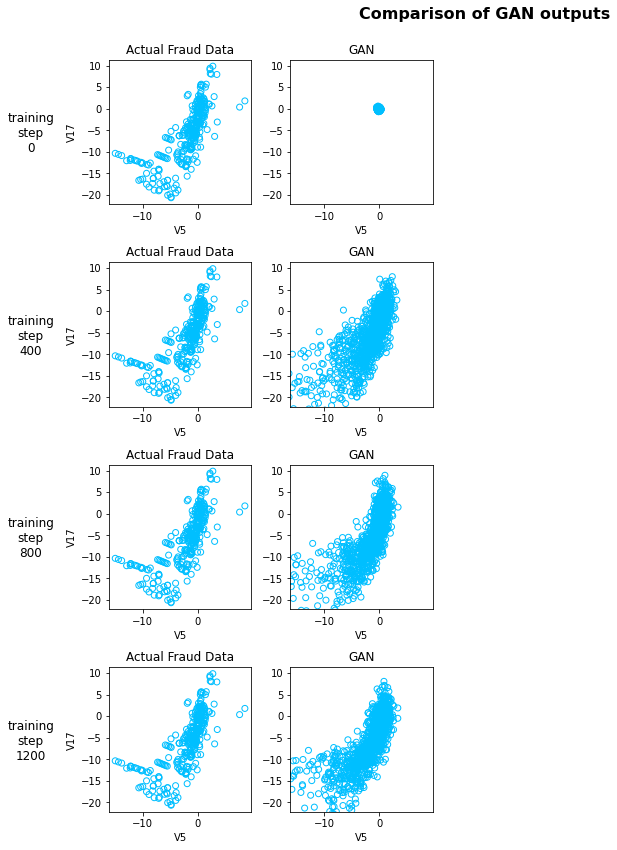

In [ ]:
# Setup parameters visualization parameters
seed = 42
test_size = train_samples.shape[0] # number of fraud cases

np.random.seed(seed)
z = np.random.normal(size=(1024, noise_dim))
real = synthesizer.get_data_batch(train=train_samples, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V5', 'V17'

base_dir = 'cache/'

#Actual fraud data visualization
model_steps = [ 0, 400, 800, 1200]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    # for group, color, marker, label in zip(real_samples.groupby('Class'), colors, markers, class_labels ):
    plt.scatter(
        real_samples[[col1]], real_samples[[col2]], 
        marker='o', edgecolors=['deepskyblue'], facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    # if model_step_ix == 0: 
        # legend = plt.legend()
        # legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            raise NotImplementedError()
            # g_z = generator_model.predict([z, labels])
            # gen_samples = pd.DataFrame(g_z, columns=data_cols)
            # for group, color, marker, label in zip( gen_samples.groupby('Class'), colors, markers, class_labels ):
            #     plt.scatter( group[1][[col1]], group[1][[col2]], 
            #                      label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            gen_samples.to_csv('Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                         marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(col1)
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')

## Generate More Synthetic Data

In [ ]:
generator = synthesizer.generator
generator.load_weights( base_dir + '_generator_model_weights_step_' + str(epochs-1) + '.h5')

In [ ]:
test_size =  1024 // batch_size * batch_size
tmp = []
for _ in range(0, test_size, batch_size):
    z = np.random.normal(size=(batch_size, noise_dim))
    g_z = generator_model.predict(z)
    tmp.append(g_z)
gen_samples = pd.DataFrame(np.concatenate(tmp, axis=0), columns=data_cols)
gen_samples.to_csv('/gdrive/My Drive/colab tmp/generated_fraud_data.csv', index=False)

## Compare Model Accuracies

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
import numpy as np
def evaluate(model, X, y, cutoff=None):
    # y_hat = model.predict(X)
    y_hat_prob = model.predict_proba(X)[:, 1]
    if cutoff:
        best_cutoff = cutoff
        best_f1 = f1_score(y, (y_hat_prob >= cutoff).astype('int'))
    else:
        best_f1, best_cutoff = 0, 0
        for cutoff in np.arange(0., 1, 0.01):
            y_hat = (y_hat_prob >= cutoff).astype('int')
            score = f1_score(y, y_hat)
            if score > best_f1:
                best_f1, best_cutoff = score, cutoff
    print(f"F1: {best_f1} @ {best_cutoff:.2f}")
    # print(f"Acc: {accuracy_score(y, y_hat)}")
    print(confusion_matrix(y, (y_hat_prob >= best_cutoff).astype('int')))
    
    print(f"AUC: {roc_auc_score(y, y_hat_prob)}")
    return best_cutoff

In [ ]:
model_params = dict(
    n_estimators=300, max_depth=8, max_leaf_nodes=2**6, class_weight="balanced_subsample"
)

### Baseline (Train Real; Test Real)

In [ ]:
y_train.shape

(12295,)

In [ ]:
model = RandomForestClassifier(**model_params)
model.fit(X_train.values, y_train.values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=64,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
cutoff = evaluate(model, X_valid.values, y_valid.values)

F1: 0.9130434782608695 @ 0.38
[[3998    2]
 [  14   84]]
AUC: 0.9802066326530612


In [ ]:
_ = evaluate(model, X_test.values, y_test.values, cutoff)

F1: 0.9081632653061225 @ 0.38
[[3992    8]
 [  10   89]]
AUC: 0.9808611111111111


### Train Real + Synthetic; Test Real

In [ ]:
X_train_both = pd.concat([X_train, gen_samples], axis=0)
y_train_both = pd.concat([y_train, pd.Series(np.ones(gen_samples.shape[0]))])
y_train_both.shape

(13255,)

In [ ]:
model = RandomForestClassifier(**model_params)
model.fit(X_train_both.values, y_train_both.values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=64,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
cutoff = evaluate(model, X_valid.values, y_valid.values)

F1: 0.9120879120879121 @ 0.61
[[3999    1]
 [  15   83]]
AUC: 0.9836147959183673


In [ ]:
_ = evaluate(model, X_test.values, y_test.values, cutoff=cutoff)

F1: 0.9072164948453608 @ 0.61
[[3993    7]
 [  11   88]]
AUC: 0.9797070707070707


### Train Synthetic; Test Real

In [ ]:
X_train_fake = pd.concat([X_train[y_train==0], gen_samples], axis=0)
y_train_fake = pd.concat([y_train[y_train==0], pd.Series(np.ones(gen_samples.shape[0]))])
y_train_fake.shape

(12960,)

In [ ]:
model = RandomForestClassifier(**model_params)
model.fit(X_train_fake.values, y_train_fake.values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=64,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
cutoff = evaluate(model, X_valid.values, y_valid.values)

F1: 0.8926553672316384 @ 0.55
[[4000    0]
 [  19   79]]
AUC: 0.983670918367347


In [ ]:
_ = evaluate(model, X_test.values, y_test.values, cutoff=cutoff)

F1: 0.8900523560209425 @ 0.55
[[3993    7]
 [  14   85]]
AUC: 0.9758131313131313
